<a href="https://colab.research.google.com/github/gardenialionita/PlatinumChallengeBinar/blob/gardenialionita-patch-1/Platinum_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q PySastrawi

     |████████████████████████████████| 210 kB 5.2 MB/s 


In [2]:
# Standar Library
import re
import string

# Third-party Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import keras
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Data Collections**

In [3]:
# Read TSV file into DataFrame
data = pd.read_table('https://gist.githubusercontent.com/gardenialionita/0e9d51539fce7bad50ef263f7b643347/raw/b2db2b370091e99193259875a33de3e478d7f0a3/train_preprocess.tsv',  names=["text", "label"])
print(data)


                                                    text     label
0      warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1      mohon ulama lurus dan k212 mmbri hujjah partai...   neutral
2      lokasi strategis di jalan sumatera bandung . t...  positive
3      betapa bahagia nya diri ini saat unboxing pake...  positive
4      duh . jadi mahasiswa jangan sombong dong . kas...  negative
...                                                  ...       ...
12239  keren , ditantang menteri susi , sandiaga gela...   neutral
12240  xiaomi , samsung , tergantung sih kamu mau tip...   neutral
12241  demokrat sodorkan subri dampingi habib hadi di...   neutral
12242  daftar obat sakit tenggorokan yang diresepkan ...   neutral
12243  tengok setya novanto di rutan kpk , deisti tum...   neutral

[12244 rows x 2 columns]


In [4]:
print('The train dataset contains {} rows and {} columns'.format(data.shape[0], data.shape[1]))

The train dataset contains 12244 rows and 2 columns


In [5]:
# cek jml data
result = data.groupby(['label']).count()
print(result)

          text
label         
negative  3436
neutral   2392
positive  6416


In [6]:
data.isnull().sum()

text     0
label    0
dtype: int64

**Text Preprocessing: Text Cleaning**
1. Pengubahan beberapa tanda baca menjadi spasi
2. Reduksi spasi yang berlebihan menjadi satu spasi
3. Penyamaan huruf besar dan kecil
4. Menghapus stopwords

In [7]:
punctuations = re.sub(r"[!<_>#:)\.]", "", string.punctuation)

def punct2wspace(text):
    return re.sub(r"[{}]+".format(punctuations), " ", text)

def normalize_wspace(text):
    return re.sub(r"\s+", " ", text)

def casefolding(text):
    return text.lower()

In [8]:
#clean stopwords
stopword = set(stopwords.words('indonesian'))
def clean_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stopword) # hapus stopword dari kolom text
    return text

In [9]:
def stemmingtokenization(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    tokens = word_tokenize(text)
    final = [stemmer.stem(tagged_word) for tagged_word in tokens]
    return " ".join(final)

In [10]:
def preprocess_text(text):
    text = punct2wspace(text)
    text = normalize_wspace(text)
    text = casefolding(text)
    text = stemmingtokenization(text)
    text = clean_stopwords(text)
    #text = final(text)
    return text

In [11]:
data["cleaned_text"] = data["text"].apply(preprocess_text)
data.head()

,text,label,cleaned_text
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung milik usaha pabrik puluh kenal putih ba...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k212 mmbri hujjah partai diw...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatera bandung nya ny...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya unboxing paket barang nya b...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh mahasiswa sombong kasih kartu kuning ajar ...


In [12]:
import os  
os.makedirs('folder/subfolder', exist_ok=True)  
data.to_csv('folder/subfolder/out.csv') 

**Text Preprocessing: Dapatkan Teks dan Label**

In [13]:
target = data["label"].map({"positive": 1, "neutral": 0, "negative":-1})
features_text = data["cleaned_text"]

**Input Pipeline: Split Data**

In [14]:
#split data
X_train, X_test, y_train, y_test = train_test_split(features_text, target,
                                                    test_size=0.2,random_state=42)

**Input Pipeline: TF Dataset**

In [15]:
#TF Dataset
BATCH_SIZE = 64

In [16]:
# Ubah input menjadi objek tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Terapkan shuffle, batch dan prefetch pada dataset
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [17]:
# Melihat isi dataset
for feat, tar in train_dataset.take(1):
    print(feat[:3])
    print(tar[:3])

tf.Tensor(
[b'nya susah temu layan nya buruk minum lumayan mahal situasi nya tarik buruk'
 b'titik jenuh libur nyata nya bab 2 acc'
 b'lumayan atmosfer nya enak santai santai bareng cerita nya sengaja pengin coba pas masuk cari pria ya langsung resto nya lapar hahaha pesan nasi bambu lupa nama nya sih minum nya sih enak lihat harga nya ya jujur mahal rekomendasi'], shape=(3,), dtype=string)
tf.Tensor([-1 -1 -1], shape=(3,), dtype=int64)


**Input Pipeline: Text Encoder**

In [18]:
#Text Encoder
max_features = 10000      # Jumlah kosakata
embedding_dim = 16        # Jumlah dimensi dalam word embedding

In [19]:
# Buat text vectorizer
encoder = keras.layers.TextVectorization(max_tokens=max_features)

# Latih tokenizer pada data teks
encoder.adapt(train_dataset.map(lambda feat, tar: feat))
     

In [20]:
# Tokenisasi data teks
encoder(feat)[:3]

<tf.Tensor: shape=(3, 40), dtype=int64, numpy=
array([[   2,  197,  121,   10,    2,  517,   32,   27,   26, 2846,    2,
          94,  517,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [1786,  935,  226,   74,    2,    1,   59,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [  27, 2062,    2,    4,  243,  243,  286,  919,    2,  540, 1709,
          14,   29,   49,   83, 1808,   25,  100,   40,    2,  358,  981,
          30,   24,  351,  181,  128,    2,   36,   32,    2,   36,    4,
          44,    5,    2,   25,  976,   26,   55]])>

Model Building

In [21]:
# Buat model sequential (berurutan)
model = keras.Sequential()
model.add(encoder)
model.add(keras.layers.Embedding(
    input_dim=len(encoder.get_vocabulary()), 
    output_dim=embedding_dim, 
    mask_zero=True)
)
model.add(keras.layers.LSTM(16, return_sequences=True))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.add(keras.layers.Dense(1, activation="sigmoid"))

# Tentukan loss, optimizer dan metrik yang akan digunakan
model.compile(loss="binary_crossentropy", 
              optimizer="adam",
              metrics=["acc"])

Struktur Model

In [22]:

# Melihat arsitektur model
model.summary()
     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, None, 16)          2112      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                        

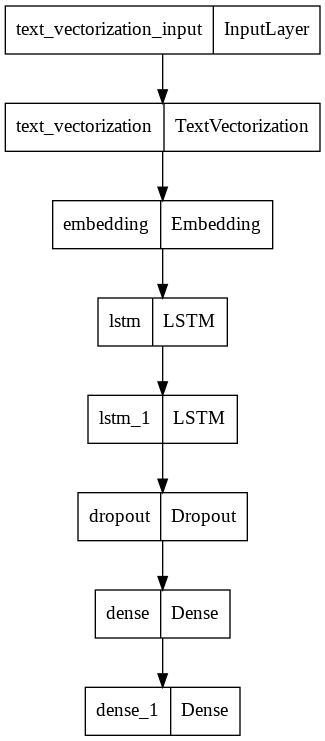

In [23]:
# Melihat Diagram Model
keras.utils.vis_utils.plot_model(model, "model.png")

In [24]:
# Melatih model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=test_dataset)
     

Epoch 1/5
154/154 [==============================] - 25s 100ms/step - loss: -0.3290 - acc: 0.4407 - val_loss: -1.5190 - val_acc: 0.6256
Epoch 2/5
154/154 [==============================] - 11s 72ms/step - loss: -2.7084 - acc: 0.6345 - val_loss: -3.0654 - val_acc: 0.6239
Epoch 3/5
154/154 [==============================] - 11s 69ms/step - loss: -4.9428 - acc: 0.6482 - val_loss: -4.9058 - val_acc: 0.6235
Epoch 4/5
154/154 [==============================] - 11s 69ms/step - loss: -7.6483 - acc: 0.6552 - val_loss: -6.7678 - val_acc: 0.6350
Epoch 5/5
154/154 [==============================] - 11s 71ms/step - loss: -10.5423 - acc: 0.6598 - val_loss: -8.5769 - val_acc: 0.6341


Model Evaluation

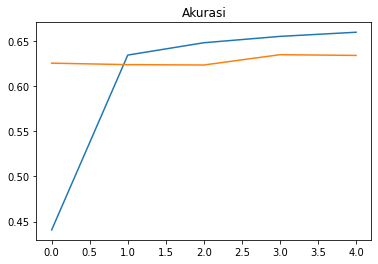

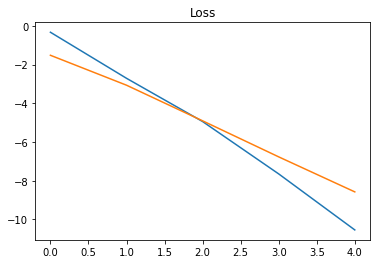

In [25]:
plt.figure()
plt.title("Akurasi")
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])

plt.figure()
plt.title("Loss")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.show()

Prediksi Model

In [26]:
contoh_text = ["Lumayan sih tapi masih mau nyoba yang lain."]
prediksi = model.predict(contoh_text) # Probabilitas
prediksi.squeeze()  # diatas 0.5 berarti label 1 atau sentimen positif, begitu juga sebaliknya

1/1 [==============================] - 3s 3s/step


array(1.8007497e-12, dtype=float32)

In [27]:
if prediksi.squeeze()>0.5:
  print(prediksi.squeeze())
  print("Review positif")
else:
  print(prediksi.squeeze())
  print("Review negatif")

1.8007497e-12
Review negatif


In [28]:
model.save_weights('mymodel_weights')
model.save('mymodel',save_format=tf)

In [29]:
# model evaluation
from keras.models import load_model

model = load_model('mymodel')
scores = model.evaluate(X_test, y_test)

LSTM_accuracy = scores[1]*100

print('Test accuracy: ', scores[1]*100, '%')

77/77 [==============================] - 6s 18ms/step - loss: -8.5769 - acc: 0.6341
Test accuracy:  63.41363787651062 %


In [30]:
tf.keras.models.load_model("mymodel")

In [31]:
contoh_text = ["lokasi strategis pusat kota, nyaman"]
prediksi = model.predict(contoh_text) # Probabilitas
prediksi.squeeze()
if prediksi.squeeze()>0.5:
  print(prediksi.squeeze())
  print("Review positif")
else:
  print(prediksi.squeeze())
  print("Review negatif")
     

1/1 [==============================] - 3s 3s/step
0.96312076
Review positif
